ToDos - last step:
- grid search order combinations of log diff series
- check the diagnostic plot
- lstm code
- TFT with future information = day, month

Armed with a high-level understanding of order demands, we will proceed to build a few models to forecast this quantity. These can be divided into three big types - the first of which, statistical models (ARIMA, SARIMAX), is what we will be trying out first. Future ToDos are machine learning (random forest, gradient boosting) and deep learning models (LSTM, Temporal Fusion Transformer). The error metrics used in this part will be MSE and MAE.

Name the steps of estimations

In [ ]:
# learn data sampling to match desired frequency and iteration over order combinations of SARIMAX from this https://www.kaggle.com/code/riyosha/forecasting-with-sarima , you'll be fine :D
# this has been an unfair fight from the start

In [1]:
!pip install pmdarima -q
!pip install arch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 17.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import polyfit
from google.colab import drive
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa import stattools
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from arch import arch_model
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import itertools
from joblib import delayed, Parallel
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/forecasting_clean.csv')
df.drop(df.columns[0],inplace=True,axis=1)
df.head()

,Product_Code,Warehouse,Product_Category,month,year,Order,Order_date,day
0,Product_0993,Whse_J,Category_028,7,2012,100.0,2012-07-27,27
1,Product_0979,Whse_J,Category_028,1,2012,500.0,2012-01-19,19
2,Product_0979,Whse_J,Category_028,2,2012,500.0,2012-02-03,3
3,Product_0979,Whse_J,Category_028,2,2012,500.0,2012-02-09,9
4,Product_0979,Whse_J,Category_028,3,2012,500.0,2012-03-02,2


In [4]:
df['Order_date'] = pd.to_datetime(df['Order_date'])
df.head()

,Product_Code,Warehouse,Product_Category,month,year,Order,Order_date,day
0,Product_0993,Whse_J,Category_028,7,2012,100.0,2012-07-27,27
1,Product_0979,Whse_J,Category_028,1,2012,500.0,2012-01-19,19
2,Product_0979,Whse_J,Category_028,2,2012,500.0,2012-02-03,3
3,Product_0979,Whse_J,Category_028,2,2012,500.0,2012-02-09,9
4,Product_0979,Whse_J,Category_028,3,2012,500.0,2012-03-02,2


In [5]:
# group into average daily form - univariate series first, will add info about time later
avg_df = df.groupby('Order_date')['Order'].mean().sort_index()
avg_df

,Order
Order_date,
2012-01-01,2.000000
2012-01-02,12147.803571
2012-01-03,8480.706186
2012-01-04,7404.920000
2012-01-05,8800.958661
...,...
2016-12-26,5642.877138
2016-12-27,3554.619958
2016-12-28,6314.059908


In [9]:
# heavily skewed
avg_df.describe()

,Order
count,1681.000000
mean,6768.704564
std,14512.955080
min,0.000000
25%,3674.776136
50%,4570.513583
75%,5796.302243
max,283333.333333


In [11]:
# winsorize the data
from scipy.stats.mstats import winsorize

wins_daily = winsorize(avg_df, limits=[0.05,0.05])
wins_daily

masked_array(data=[  400.        , 12147.80357143,  8480.70618557, ...,
                    6314.05990783,  6391.40963855, 13777.70769231],
             mask=False,
       fill_value=1e+20)

In [71]:
daily_avg = pd.Series(wins_daily.data, index = avg_df.index).rename('daily')
daily_avg.describe()

,daily
count,1681.000000
mean,5006.897360
std,2925.840960
min,400.000000
25%,3674.776136
50%,4570.513583
75%,5796.302243
max,13777.707692


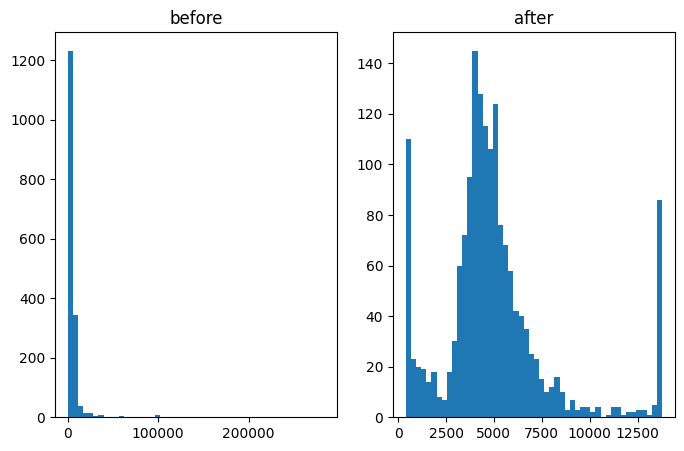

In [17]:
# compare distribution of data before and after winsorization
fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].hist(avg_df, bins=50)
ax[0].set_title('before')
ax[1].hist(daily_avg, bins=50)
ax[1].set_title('after');

In [18]:
# reject null hypothesis of unit root
def unit_root(series):
  res = stattools.adfuller(avg_df)[1]
  if res <= 0.05:
    return f"p-val is {res}: Reject unit root => stationary"
  else:
    return "Fail to reject unit root"

In [19]:
unit_root(daily_avg)

'p-val is 2.586899706028665e-15: Reject unit root => stationary'

In [20]:
# this tests whether past residuals are related to current variance, to be used on residuals after mean modeling
def arch_test(residual_series):
  _, p_value, _, _ = het_arch(residual_series)
  if p_value < 0.05:
      return(f"p-value: {p_value} => ARCH detected.")
  else:
      return("No ARCH detected.")

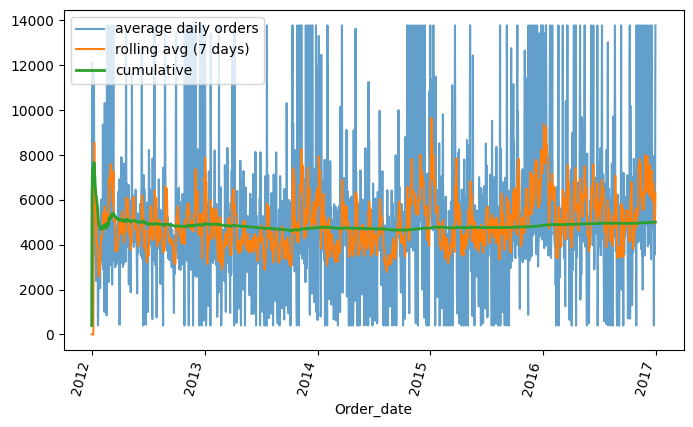

In [23]:
# plot means
window = 7
plt.figure(figsize=(8,5))
daily_avg.plot(label='average daily orders',alpha=0.7)
daily_avg.rolling(window).mean().fillna(0).plot(label=f'rolling avg ({window} days)')
(daily_avg.cumsum()/np.arange(1,len(daily_avg)+1)).plot(label='cumulative',linewidth=2)
# plt.yscale('log')
plt.legend()
plt.xticks(rotation=75);

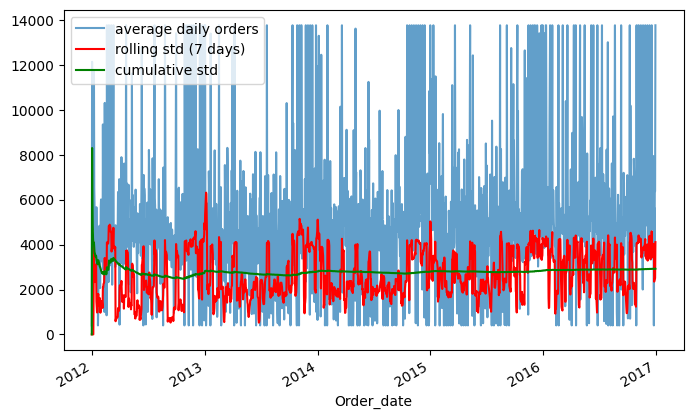

In [26]:
# volatility seemingly present, periods of low variance followed by high variance
plt.figure(figsize=(8,5))
daily_avg.plot(label='average daily orders', alpha=0.7)
daily_avg.rolling(window).std().fillna(0).plot(label=f'rolling std ({window} days)',color='red')
daily_avg.expanding().std().fillna(0).plot(label='cumulative std',color='green')
plt.legend(loc='upper left');

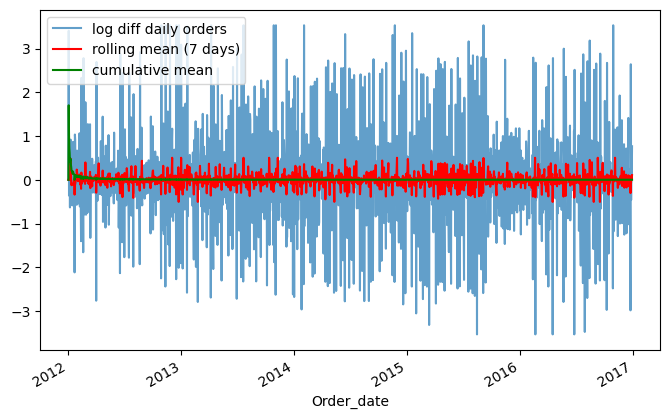

In [27]:
# plot log diff
window = 7
plt.figure(figsize=(8,5))
log_diff = np.log1p(daily_avg).diff(1).fillna(0)
log_diff.plot(label='log diff daily orders', alpha=0.7)
log_diff.rolling(window).mean().fillna(0).plot(label=f'rolling mean ({window} days)',color='red')
log_diff.expanding().mean().fillna(0).plot(label='cumulative mean',color='green')
plt.legend(loc='upper left');

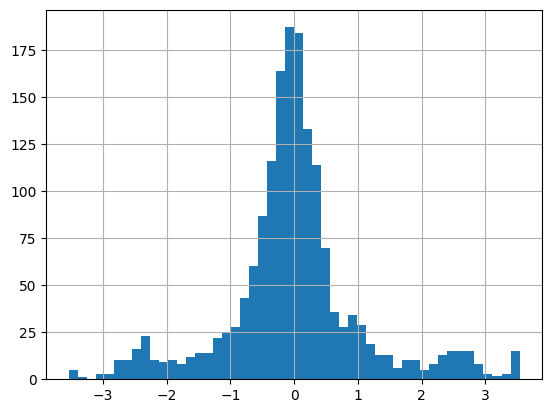

In [28]:
log_diff.hist(bins=50);

''

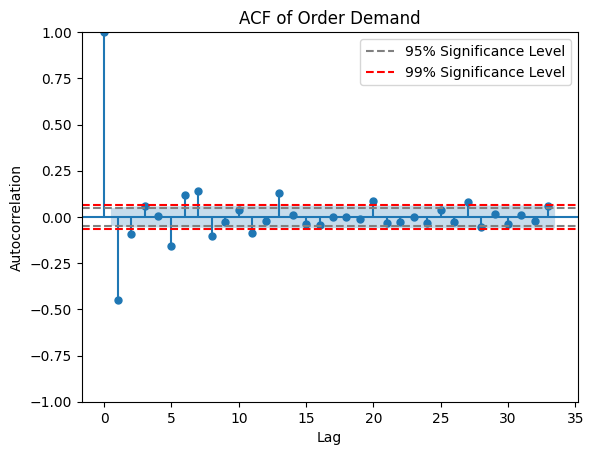

In [30]:
# ACF and PACF of log diff
critical_95 = 1.96 / (len(log_diff)**0.5)
critical_99 = 2.58 / (len(log_diff)**0.5)
fig, ax = plt.subplots()
plot_acf(log_diff, ax=ax,alpha=0.05)

ax.axhline(y=critical_95, linestyle='--', color='gray', linewidth=1.5, label='95% Significance Level')
ax.axhline(y=-critical_95, linestyle='--', color='gray', linewidth=1.5)
ax.axhline(y=critical_99, linestyle='--', color='red', linewidth=1.5, label='99% Significance Level')
ax.axhline(y=-critical_99, linestyle='--', color='red', linewidth=1.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Order Demand')
plt.legend();

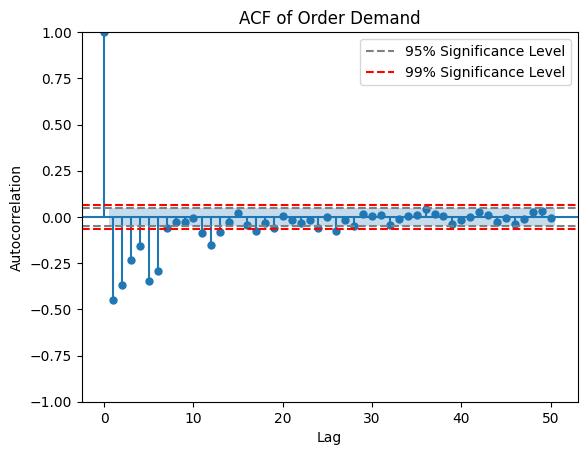

In [31]:
fig, ax = plt.subplots()
plot_pacf(log_diff, ax=ax, lags=50,alpha=0.05)

ax.axhline(y=critical_95, linestyle='--', color='gray', linewidth=1.5, label='95% Significance Level')
ax.axhline(y=-critical_95, linestyle='--', color='gray', linewidth=1.5)
ax.axhline(y=critical_99, linestyle='--', color='red', linewidth=1.5, label='99% Significance Level')
ax.axhline(y=-critical_99, linestyle='--', color='red', linewidth=1.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Order Demand')
plt.legend();

Analyze the 2 plots, Looks like MA sth

In [33]:
# decompose
def fit(X, y, degree=3):
  coef = polyfit(X,y,degree)
  trend_poly = np.poly1d(coef)
  return trend_poly(X)

def seasonality(series, periods=4, degree=3):
  X = [i%(365/4) for i in range(0, len(series))]
  seasonals = fit(X,series.values,degree)
  return pd.Series(data=seasonals, index=series.index)

def trend(series, degree=3):
  X = np.arange(len(series))
  trend = fit(X,series.values,degree)
  return pd.Series(data=trend,index=series.index)

decomp_df = pd.concat([daily_avg,trend(daily_avg).rename('trend'),seasonality(daily_avg).rename('seasonality')],axis=1)
decomp_df

,daily,trend,seasonality
Order_date,,,
2012-01-01,400.000000,5212.925868,5212.767410
2012-01-02,12147.803571,5210.037369,5190.346875
2012-01-03,8480.706186,5207.156126,5169.059547
2012-01-04,7404.920000,5204.282131,5148.881322
2012-01-05,8800.958661,5201.415380,5129.788101
...,...,...,...
2016-12-26,5642.877138,5827.433058,4940.803954
2016-12-27,3554.619958,5828.230801,4943.225382
2016-12-28,6314.059908,5829.025681,4945.972605


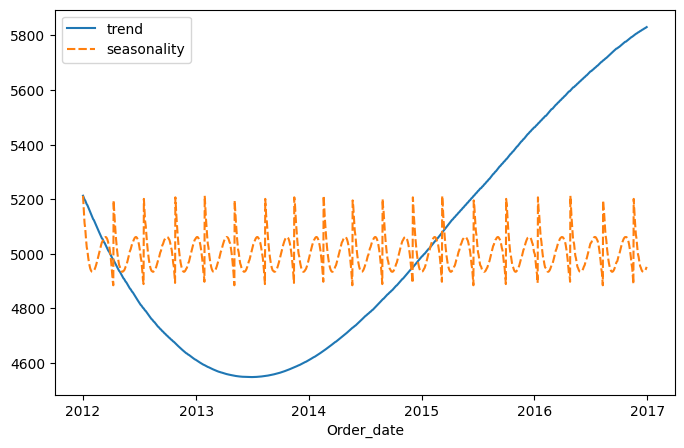

In [37]:
plt.figure(figsize=(8,5))
sns.lineplot(data=decomp_df.drop('daily', axis=1));

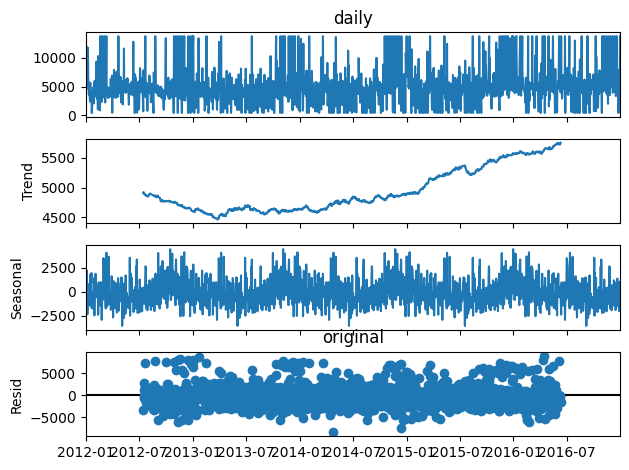

In [38]:
seasonal_decompose(daily_avg, model='additive',period=365).plot();
plt.title('original');

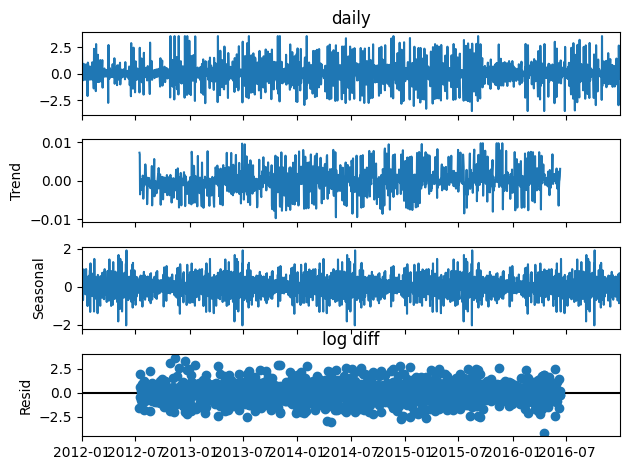

In [39]:
# log diff removes trend
seasonal_decompose(log_diff, model='additive', period=365).plot()
plt.title('log diff');

In [46]:
# # manually grid search for all orders
# d = [0,1]
# p = range(0,3)
# q = range(0,3)
# P = Q = range(0,2)
# D = [0]
# O = [7]
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(P,D,Q,O))]
# param_comb = list(itertools.product(pdq, seasonal_pdq))

# def fit_sarima(params, ts_data):
#     param, param_seasonal = params
#     try:
#         model = SARIMAX(ts_data,
#                         order=param,
#                         seasonal_order=param_seasonal,
#                         enforce_stationarity=False,
#                         enforce_invertibility=False)
#         results = model.fit(disp=False, method='lbfgs')
#         return f'{param}x{param_seasonal}', results.aic
#     except Exception as e:
#         print(f"Error for SARIMA{param}x{param_seasonal}: {e}")
#         return f'{param}x{param_seasonal}', np.inf  # Assign high AIC for failures

# num_cores = -1
# results = Parallel(n_jobs=num_cores)(delayed(fit_sarima)(params,daily_avg) for params in param_comb)

In [47]:
# # fit again after differencing, d = 0
# d = range(0,1)
# p = range(0,3)
# q = range(0,3)
# P = D = Q = range(0,2)
# O = [7,30,365]
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(P,D,Q, O))]
# param_comb = list(itertools.product(pdq, seasonal_pdq))
# results_integrated = Parallel(n_jobs=num_cores)(delayed(fit_sarima)(params,log_diff) for params in param_comb)

In [48]:
# aic_results = pd.join(pd.DataFrame(results, columns=['model', 'aic']),pd.DataFrame(results_integrated, columns=['model','aic_integrated']), on='model')
# aic_results.sort_values(by='aic',ascending=True)

In [49]:
# aic_results.sort_values(by='aic_integrated',ascending=True)

In [50]:
# aic_results.plot();

In [42]:
# use auto_arima
best_model = pm.auto_arima(daily_avg,
                           seasonal=True,
                           stepwise=True,
                           trace=True,
                           suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31564.212, Time=7.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32722.441, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32283.408, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31568.580, Time=2.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32720.448, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31571.282, Time=2.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31564.289, Time=2.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=31565.706, Time=3.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=31558.504, Time=6.78 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=31567.143, Time=2.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=31560.252, Time=3.47 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=31560.207, Time=4.24 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=31569.324, Time=7.32 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=31562.064, Time=5.03 sec
 ARIMA(2,1,3)(0,0,0

In [44]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1681
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -15772.136
Date:                Tue, 04 Feb 2025   AIC                          31556.272
Time:                        03:12:05   BIC                          31588.831
Sample:                             0   HQIC                         31568.333
                               - 1681                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5203      0.045    -11.594      0.000      -0.608      -0.432
ar.L2         -0.9170      0.046    -19.842      0.000      -1.008      -0.826
ma.L1         -0.4838      0.054     -8.906      0.000      -0.590      -0.377
ma.L2          0.3985      0.070      5.667      0.000       0.261       0.536
ma.L3         -0.8537      0.056    -15.352      0.000      -0.963      -0.745
sigma2      8.811e+06   2.18e-09   4.04e+15      0.000    8.81e+06    8.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               846.65
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.57e+31. Standard errors may be unstable.
"""

In [45]:
best_model_integrated = pm.auto_arima(log_diff,
                           seasonal=True,
                           stepwise=True,
                           trace=True,
                           suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3887.240, Time=8.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5041.245, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4667.588, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3910.042, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5039.252, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3912.080, Time=1.75 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3893.546, Time=1.18 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3895.896, Time=4.77 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3912.038, Time=1.23 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3889.378, Time=3.01 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3893.911, Time=3.17 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3885.354, Time=1.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3

In [88]:
# model using this best fit
final_model = SARIMAX(log_diff,
                      order = (2,1,3),
                      enforce_stationarity=True,
                      enforce_invertibility=True).fit()

In [89]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  daily   No. Observations:                 1681
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1959.222
Date:                Tue, 04 Feb 2025   AIC                           3930.443
Time:                        03:33:00   BIC                           3963.003
Sample:                             0   HQIC                          3942.504
                               - 1681                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9998      0.036    -27.968      0.000      -1.070      -0.930
ar.L2         -0.0004      0.021     -0.020      0.984      -0.042       0.041
ma.L1         -0.9844      0.042    -23.717      0.000      -1.066      -0.903
ma.L2         -0.9996      0.080    -12.565      0.000      -1.155      -0.844
ma.L3          0.9839      0.039     24.983      0.000       0.907       1.061
sigma2         0.5970      0.018     33.015      0.000       0.562       0.632
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1035.06
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -1.47
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
weekdays = daily_avg.index.dayofweek

In [73]:
daily_avg_df = pd.DataFrame(daily_avg,columns=['daily'])
# add day of the week in exogeneous vars, use sine-cosine encoding
daily_avg_df['sin_day'] = np.sin(2* np.pi * weekdays / 7)
daily_avg_df['cos_day'] = np.cos(2* np.pi * weekdays / 7)

In [75]:
daily_avg_df

,daily,sin_day,cos_day
Order_date,,,
2012-01-01,400.000000,-0.781831,0.623490
2012-01-02,12147.803571,0.000000,1.000000
2012-01-03,8480.706186,0.781831,0.623490
2012-01-04,7404.920000,0.974928,-0.222521
2012-01-05,8800.958661,0.433884,-0.900969
...,...,...,...
2016-12-26,5642.877138,0.000000,1.000000
2016-12-27,3554.619958,0.781831,0.623490
2016-12-28,6314.059908,0.974928,-0.222521


In [84]:
# model using this best fit
final_model_exog = SARIMAX(log_diff,
                      exog=daily_avg_df['cos_day'],
                      order = (2,1,3),
                      enforce_stationarity=True,
                      enforce_invertibility=True).fit()

In [85]:
final_model_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  daily   No. Observations:                 1681
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1913.993
Date:                Tue, 04 Feb 2025   AIC                           3841.985
Time:                        03:28:40   BIC                           3879.971
Sample:                             0   HQIC                          3856.056
                               - 1681                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cos_day        0.2166      0.022      9.994      0.000       0.174       0.259
ar.L1         -1.0566      0.023    -45.075      0.000      -1.103      -1.011
ar.L2         -0.0583      0.022     -2.666      0.008      -0.101      -0.015
ma.L1         -0.9564      0.014    -69.252      0.000      -0.984      -0.929
ma.L2         -0.9987      0.020    -48.802      0.000      -1.039      -0.959
ma.L3          0.9552      0.013     72.541      0.000       0.929       0.981
sigma2         0.5663      0.017     32.811      0.000       0.532       0.600
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               506.75
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -1.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

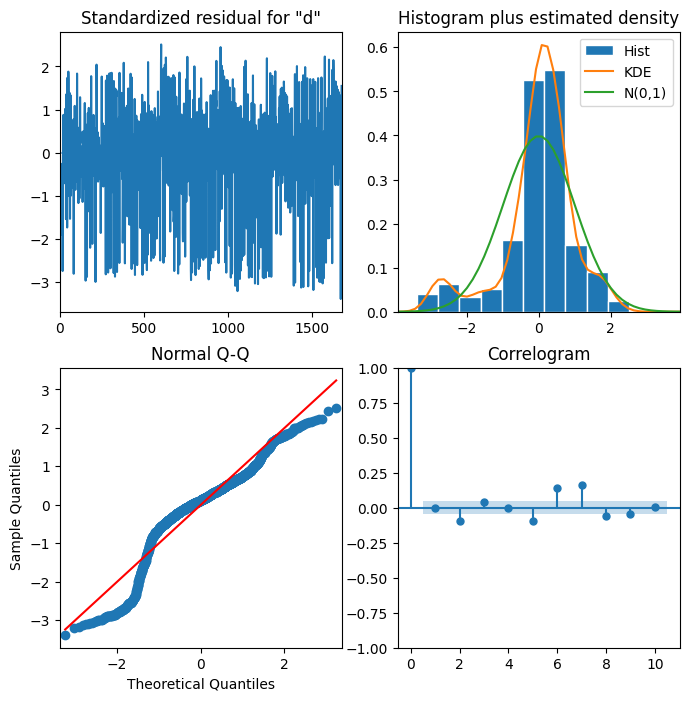

In [86]:
# check diagnostic plot
final_model_exog.plot_diagnostics(figsize=(8,8));


In [87]:
# check presence of ARCH, model errors
arch_test(final_model_exog.resid)

'p-value: 1.070745856080362e-60 => ARCH detected.'

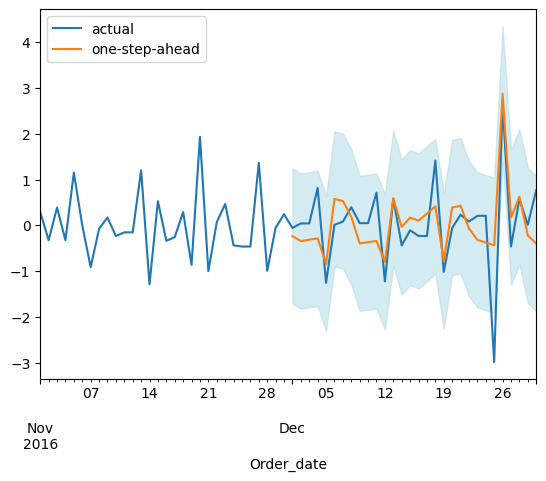

In [291]:
# get insample predictions and mse first
predictions = final_model_exog.get_prediction(start=pd.to_datetime('2016-12-01'), dynamic=False)
predictions_ci = predictions.conf_int()
ax = log_diff['2016-11-01':].plot(label='actual')
predictions.predicted_mean.plot(ax=ax, label='one-step-ahead')
ax.fill_between(predictions_ci.index,
                predictions_ci.iloc[:,0],
                predictions_ci.iloc[:,1],
                color='lightblue',alpha=0.5)
plt.legend();

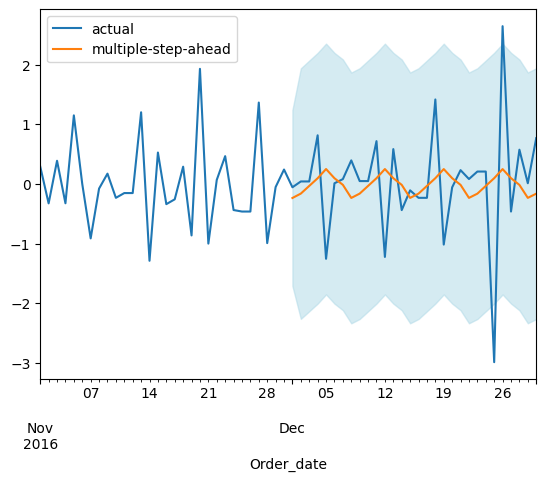

In [290]:
# setting dynamics = True makes predictions converge to unconditional mean value with widening variance
predictions = final_model_exog.get_prediction(start=pd.to_datetime('2016-12-01'), dynamic=True)
predictions_ci = predictions.conf_int()
ax = log_diff['2016-11-01':].plot(label='actual')
predictions.predicted_mean.plot(ax=ax, label='multiple-step-ahead')
ax.fill_between(predictions_ci.index,
                predictions_ci.iloc[:,0],
                predictions_ci.iloc[:,1],
                color='lightblue',alpha=0.5)
plt.legend();

But possible overfitting above because we used all data

In [172]:
log_diff = log_diff.asfreq('D').fillna(method='ffill')
log_diff.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-24',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Order_date', length=1826, freq='D')

In [125]:
daily_avg_df = daily_avg_df.asfreq('D')
daily_avg_df.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-24',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Order_date', length=1826, freq='D')

In [301]:
# train_test_split, reset index to be sure
k = int(len(train_data)*0.9)
train_data = log_diff.iloc[:k]
test_data = log_diff.iloc[k:]
print(train_data.shape, test_data.shape)

(1308,) (518,)


In [205]:
# fillna
daily_avg_df.fillna(method='ffill',inplace=True)
daily_avg_df.isnull().sum()

,0
daily,0
sin_day,0
cos_day,0


In [206]:
# fit on train
model = SARIMAX(train_data,
                      exog=daily_avg_df['cos_day'][:len(train_data)],
                      order = (2,1,3),
                      enforce_stationarity=True,
                      enforce_invertibility=True).fit()

In [207]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  daily   No. Observations:                 1453
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1701.976
Date:                Tue, 04 Feb 2025   AIC                           3417.951
Time:                        04:40:41   BIC                           3454.916
Sample:                    01-01-2012   HQIC                          3431.744
                         - 12-23-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cos_day        0.2408      0.027      8.944      0.000       0.188       0.294
ar.L1         -0.9446      0.041    -22.786      0.000      -1.026      -0.863
ar.L2         -0.0075      0.027     -0.274      0.784      -0.061       0.046
ma.L1         -0.9384      0.035    -27.130      0.000      -1.006      -0.871
ma.L2         -0.9254      0.062    -14.829      0.000      -1.048      -0.803
ma.L3          0.8658      0.033     26.179      0.000       0.801       0.931
sigma2         0.6086      0.019     31.673      0.000       0.571       0.646
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               365.94
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [208]:
# insample MSE
model.mse, model.mae

(0.6176291703457671, 0.561476308802812)

In [209]:
# for each new time step, update data, refit and forecast
forecasts = []
for step in range(len(test_data)):
  exog_val = daily_avg_df['cos_day'][(k+step):(k+step+1)]
  forecasts.append(model.forecast(exog=exog_val))
  model = model.extend(test_data[step:step+1],exog=exog_val)

In [210]:
out_sample_fc = pd.concat([fc for fc in forecasts]).rename('out_sample_fc')

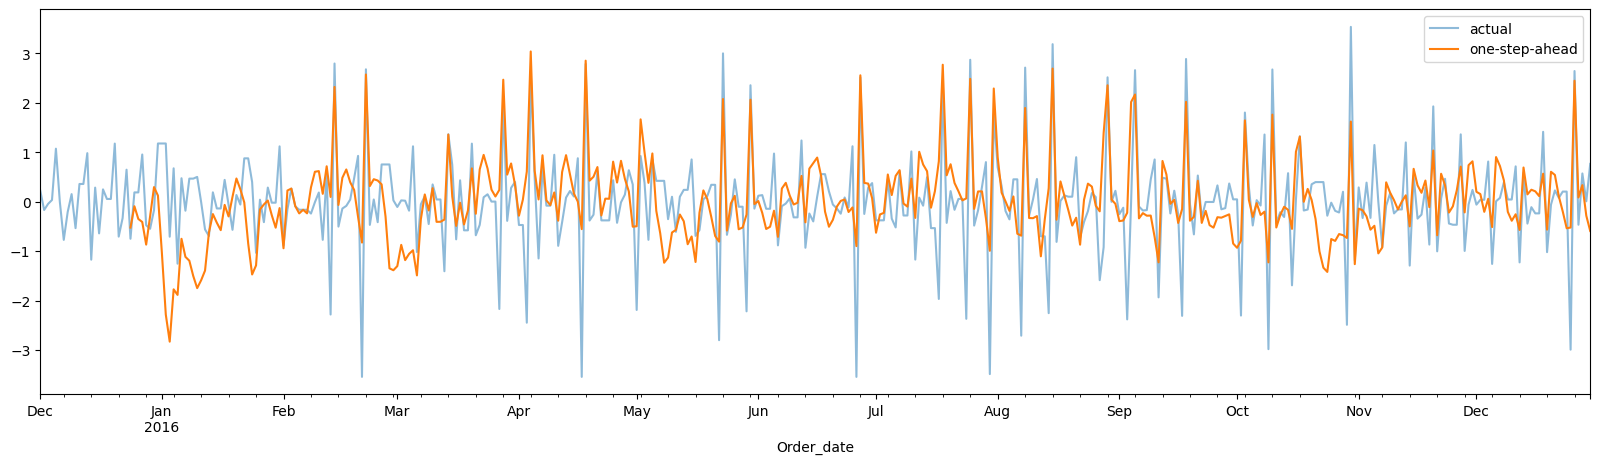

In [218]:
ax = log_diff['2015-12-01':].plot(label='actual',alpha=0.5)
out_sample_fc.plot(ax=ax, label='one-step-ahead',figsize=(20,5))
plt.legend();

In [211]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(test_data, out_sample_fc), mean_absolute_error(test_data, out_sample_fc)

(0.8218984220348895, 0.6513828183949314)

In [223]:
# can model ARCH later
out_resid = test_data - out_sample_fc
print('Out-sample:',arch_test(out_resid))

Out-sample: p-value: 3.471156214424501e-08 => ARCH detected.


In [ ]:
# garch_model = arch_model(y=residuals, mean='Zero', vol='egarch',lags=1,o=1,p=2,q=2).fit(disp='off')
# garch_model.summary()

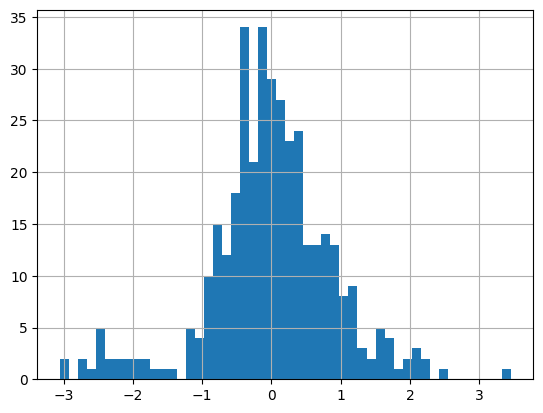

In [217]:
out_resid.hist(bins=50);

**LSTM**

In [225]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
tqdm.pandas()

In [237]:
sequence_length = 50
X_train, y_train = [], []
for i in range(len(train_data) - sequence_length):
  X_train.append(train_data[i:i+sequence_length])
  y_train.append(train_data[i+sequence_length])
X_train = torch.tensor(X_train,dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train,dtype=torch.float32).unsqueeze(-1)

In [233]:
X_test, y_test = [], []
for i in range(len(test_data) - sequence_length):
  X_test.append(test_data[i:i+sequence_length])
  y_test.append(test_data[i+sequence_length])
X_test = torch.tensor(X_test,dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test,dtype=torch.float32).unsqueeze(-1)

In [228]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.linear = nn.Linear(hidden_size,1)

  def forward(self, x):
    out, _ = self.lstm(x) # out.shape = (B, T, Channel or hidden states?)
    out = self.linear(out[:, -1, :]) # focus on the last time step only
    return out

In [229]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [243]:
# hyperparam config
input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2
model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss = nn.MSELoss(reduction='mean') # mean across batch
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50

In [244]:
train_losses, test_losses = [], [] # loss per each epoch

for epoch in range(num_epochs):
  total_loss = 0.0 # hold sum of average losses for each batch
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    predictions = model(batch_X)
    cost = loss(predictions, batch_y)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    total_loss += cost.item()
  average_loss = total_loss / len(train_loader)
  train_losses.append(average_loss)

  model.eval()
  with torch.no_grad():
    total_test_loss = 0
    for batch_X_test, batch_y_test in test_loader:
      batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
      predictions_test = model(batch_X_test)
      cost_test = loss(predictions_test, batch_y_test)
      total_test_loss += cost_test.item()
    average_test_loss = total_test_loss / len(test_loader)
    test_losses.append(average_test_loss)
  if (epoch + 1) % 1 == 0:
      print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [1/50] - Training Loss: 1.1097, Test Loss: 1.0558
Epoch [2/50] - Training Loss: 0.8131, Test Loss: 0.6749
Epoch [3/50] - Training Loss: 0.6358, Test Loss: 0.6626
Epoch [4/50] - Training Loss: 0.6310, Test Loss: 0.6452
Epoch [5/50] - Training Loss: 0.6265, Test Loss: 0.6437
Epoch [6/50] - Training Loss: 0.6083, Test Loss: 0.6196
Epoch [7/50] - Training Loss: 0.5872, Test Loss: 0.6421
Epoch [8/50] - Training Loss: 0.5537, Test Loss: 0.6685
Epoch [9/50] - Training Loss: 0.5335, Test Loss: 0.6321
Epoch [10/50] - Training Loss: 0.5209, Test Loss: 0.5992
Epoch [11/50] - Training Loss: 0.5348, Test Loss: 0.6231
Epoch [12/50] - Training Loss: 0.5447, Test Loss: 0.6568
Epoch [13/50] - Training Loss: 0.5222, Test Loss: 0.6085
Epoch [14/50] - Training Loss: 0.5090, Test Loss: 0.6049
Epoch [15/50] - Training Loss: 0.4897, Test Loss: 0.6189
Epoch [16/50] - Training Loss: 0.4942, Test Loss: 0.6693
Epoch [17/50] - Training Loss: 0.5101, Test Loss: 0.6189
Epoch [18/50] - Training Loss: 0.4763, T

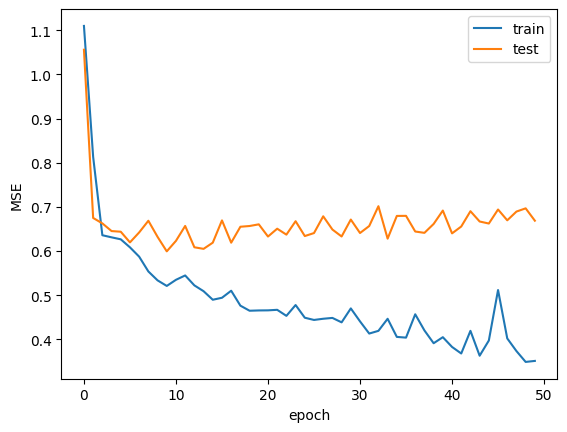

In [245]:
pd.DataFrame({'train':train_losses, 'test':test_losses}).plot()
plt.xlabel('epoch')
plt.ylabel('MSE');

In [282]:
num_forecast_steps = len(test_data)
historical_data = X_train[-1].squeeze().cpu().numpy()

In [284]:
# forecast using accumulated predictions
forecasts_test_acc = []
historical_acc_arr = historical_data.copy()
with torch.no_grad():
  for _ in range(num_forecast_steps):
    historical_acc = torch.tensor(historical_acc_arr).view(1,-1,1).float().to(device)
    predicted = model(historical_acc).cpu().numpy().item()
    forecasts_test_acc.append(predicted)
    historical_acc_arr = np.roll(historical_acc_arr,shift=-1)
    historical_acc_arr[-1] = predicted

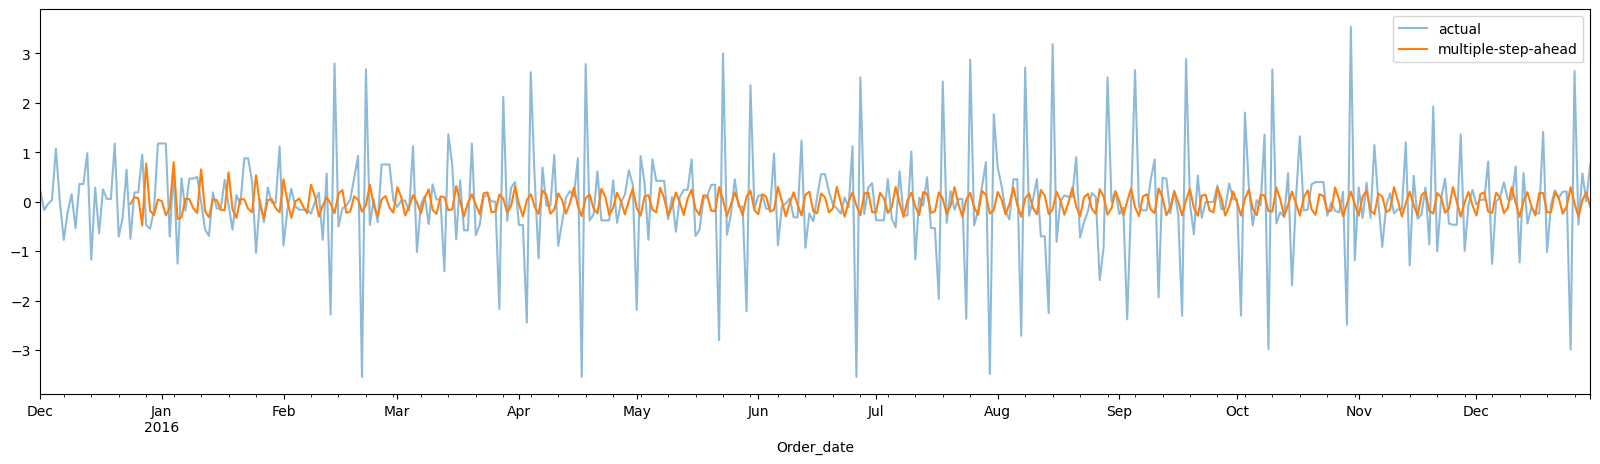

In [289]:
ax = log_diff['2015-12-01':].plot(label='actual',alpha=0.5)
pd.Series(forecasts_test_acc,index=test_data.index).plot(ax=ax, label='multiple-step-ahead',figsize=(20,5))
plt.legend();

In [287]:
# forecast using real values
forecasts_test_real = []
historical_real_arr = historical_data.copy()
with torch.no_grad():
  for _ in range(num_forecast_steps):
    historical_data_real = torch.tensor(historical_real_arr).view(1,-1,1).float().to(device)
    predicted = model(historical_data_real).cpu().numpy().item()
    forecasts_test_real.append(predicted)
    historical_real_arr = np.roll(historical_real_arr,shift=-1)
    historical_real_arr[-1] = test_data[_]

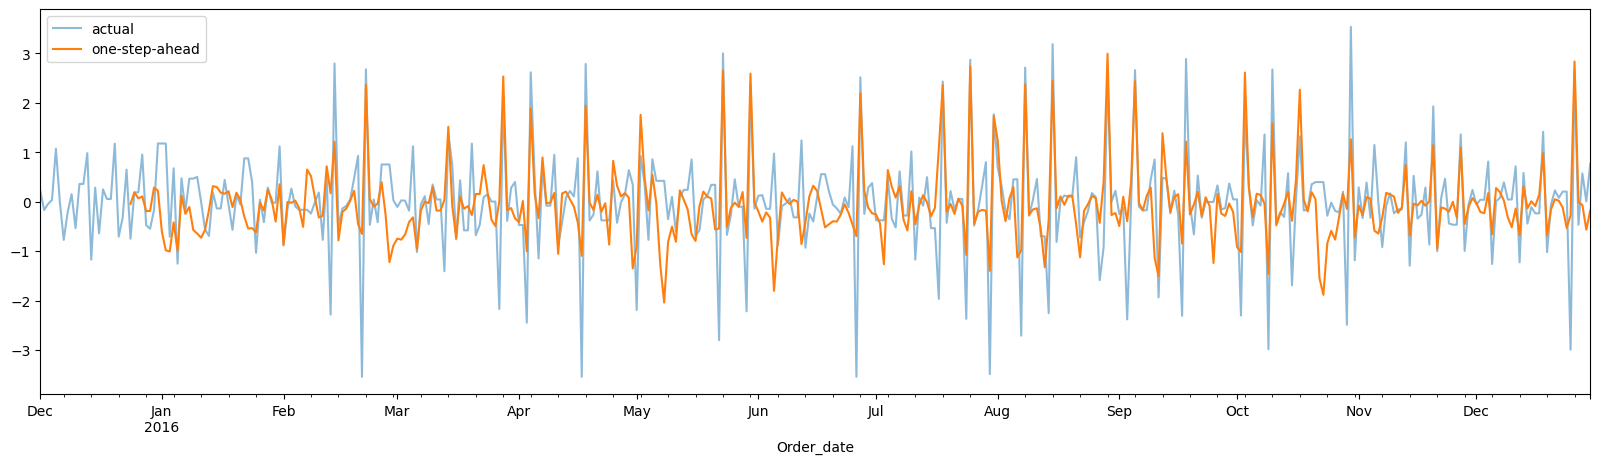

In [288]:
ax = log_diff['2015-12-01':].plot(label='actual',alpha=0.5)
pd.Series(forecasts_test_real,index=test_data.index).plot(ax=ax, label='one-step-ahead',figsize=(20,5))
plt.legend();

In [294]:
mean_squared_error(test_data, forecasts_test_real), mean_absolute_error(test_data, forecasts_test_real)

(0.6512840131835119, 0.5475383494327885)